# BlazeFace Inference Tutorial

This is a brief tutorial that shows how to use a trained BlazeFace for inference on the Pascal VOC datasets.

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.compat.v2.config.experimental.set_memory_growth(gpu, True)
    
import math
import keras
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
import cv2
from imageio import imread	
import numpy as np
from matplotlib import pyplot as plt

from models.keras_blazeface import blazeface
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxesBlazeFace import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder_blazeface import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from mtcnn import MTCNN



%matplotlib inline

Using TensorFlow backend.
/workspace/blazeface_keras/data_generator/object_detection_2d_data_generator.py:44: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


In [3]:
# Set the image size.
img_height = 256
img_width = 256

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [4]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = blazeface(image_size=(img_height, img_width, 3),
                n_classes=1,
                mode='inference',
                l2_regularization=0.0005,
                scales=[[0.2]], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0]],
                steps=[64],
                offsets=None,
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[107, 105, 109],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.1,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=100)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'checkpoint/new_anchor_256_16x16_fix_DBset_2_epoch-83_loss-0.8404.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [5]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 256, 256, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_channel_swap (Lambda)     (None, 256, 256, 3)  0           input_mean_normalization[0][0]   
____________________________________________________________________________________________

Or

### 1.2. Load a trained model

In [6]:
# # TODO: Set the path to the `.h5` file of the model to be loaded.
# model_path = 'blazeface_1class_fddb_07+12_epoch-33_loss-4.3087_val_loss-2.9612.h5'

# # We need to create an SSDLoss object in order to pass that to the model loader.
# ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

# K.clear_session() # Clear previous models from memory.

# model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
#                                                'L2Normalization': L2Normalization,
#                                                'DecodeDetections': DecodeDetections,
#                                                'compute_loss': ssd_loss.compute_loss})

## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [100]:
import random
import pandas as pd
csv = pd.read_csv('/data/tsmoon_set/valid_setting_2_new.csv')

In [108]:
imgs = csv.img_path.tolist()
test_image_name = random.choice(imgs)
print(test_image_name)
x = csv[csv.img_path == test_image_name]
xmin, ymin, xmax, ymax = int(x.xmin), int(x.ymin), int(x.xmax), int(x.ymax)
w = xmax - xmin
h = ymax - ymin
cx = int(xmin + w//2)
cy = int(ymin + h//2)
xmin = cx - 128
ymin = cy - 128
xmax = cx + 128
ymax = cy + 128
print(x.iloc[:,1:5])
print(f"xmin,ymin,xmax, ymax: {xmin},{ymin},{xmax},{ymax}")

Korea_Female_1/20200903_night_normal_01/Class_2/frame/1_20200903_night_normal_01/1_20200903_night_normal_01_16 13.jpg
      xmin  ymin  xmax  ymax
2525   366   143   507   357
xmin,ymin,xmax, ymax: 308,122,564,378


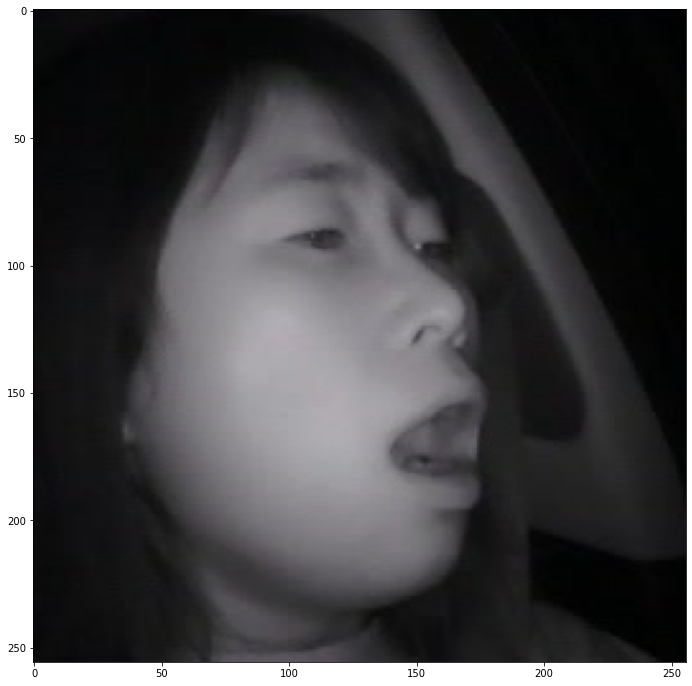

In [109]:
crop_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = f'/data/{test_image_name}'
# img_path = './test/2.jpg'
# detector = MTCNN()
ori_image = cv2.imread(img_path)
ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
ori_image = ori_image[ymin:ymax, xmin:xmax]
plt.figure(figsize=(20,12))
plt.imshow(ori_image)
ori_image = cv2.resize(ori_image, dsize=(256,256), interpolation=cv2.INTER_LINEAR)
ori_images = np.array([ori_image])
input_images = np.array(ori_images)
# input_images.append(ori_images)


# crop_data = detector.detect_faces(ori_image)

# for i in crop_data:
    
#     crop_image = ori_image[int(i['box'][1]):int(i['box'][1])+int(i['box'][3]), int(i['box'][0]):int(i['box'][0])+int(i['box'][2]),:]#keypoints, confidence
#     crop_images.append(crop_image)
#     print(crop_image.shape)
# #     img = image.load_img(img_path, target_size=(img_height, img_width))
# #     img = image.img_to_array(img)
# #     print(img.shape)
# #     img = img[int(i['box'][0]):int(i['box'][0])+int(i['box'][2]), int(i['box'][1]):int(i['box'][1])+int(i['box'][3]),:]
#     crop_image = cv2.resize(crop_image, dsize=(128,128), interpolation=cv2.INTER_LINEAR)
#     input_images.append(crop_image)
# input_images = np.array(input_images)
# print(input_images.shape)

## 3. Make predictions

In [110]:
from time import time

start = time()
# y_pred = model.predict(input_images)
y_pred = model.predict(input_images)
print(time() - start)

0.036820173263549805


`y_pred` contains a fixed number of predictions per batch item (200 if you use the original model configuration), many of which are low-confidence predictions or dummy entries. We therefore need to apply a confidence threshold to filter out the bad predictions. Set this confidence threshold value how you see fit.

In [111]:
confidence_threshold = 0.5
print(y_pred.shape)
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('class conf xmin ymin xmax ymax kp1_x kp1_y kp2_x kp2_y kp3_x kp3_y kp4_x kp4_y kp5_x kp5_y')
print(y_pred_thresh[0])
print(y_pred_thresh[0].shape)

(1, 2, 52)
Predicted boxes:

class conf xmin ymin xmax ymax kp1_x kp1_y kp2_x kp2_y kp3_x kp3_y kp4_x kp4_y kp5_x kp5_y
[]
(0, 52)


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

In [112]:
anchor = [ float(x) for x in open('anchor_256_fix.txt').readline().split(',') if x != '']

In [113]:
pred_8x8 = y_pred[0][0]
pred_16x16 = y_pred[0][1]
prediction = (pred_8x8 + pred_16x16)/2
print(prediction)

[ -24.18  -58.36 -128.2   -51.95  -67.83  -56.39  -95.51  -55.43  -45.19  -49.23  -45.51
  -56.8  -112.8   -48.74 -113.7   -56.18    8.25   -5.24 -121.11  -74.88    5.36   -4.84
  -97.15  -76.76    8.46   -5.19    7.52   -7.31 -110.66  -71.75 -111.03  -79.48  -67.59
 -120.7  -106.19 -119.47  -94.93 -113.45  -90.02 -126.23   18.96   -0.57 -109.76 -156.47
   21.13  -10.8    21.59   -9.34   20.84    3.34   24.39    7.92]


In [114]:
output = np.add(prediction, anchor)

In [115]:
dbset = [9,11,13,14,21,23,24,25,26]
output_index = []
for i in dbset:
    output_index.append(i*2-2)
    output_index.append(i*2-1)

In [116]:
output_index

[16, 17, 20, 21, 24, 25, 26, 27, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51]

In [117]:
output = output[output_index]

In [118]:
output

array([ 97.69,  93.65, 122.09,  93.69, 112.42,  88.82, 111.69,  94.93, 137.75, 179.47,
       169.43, 156.23, 169.3 , 164.89, 167.95, 182.69, 172.17, 196.83])

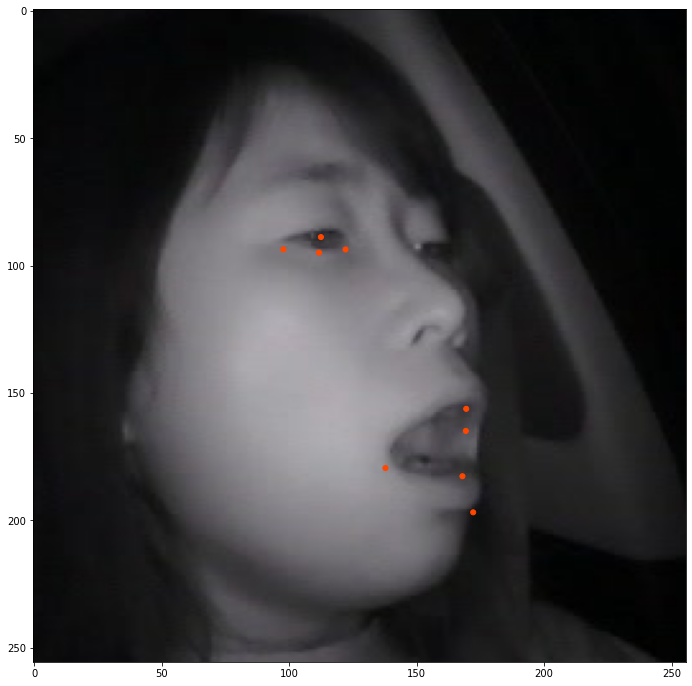

In [119]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'face']

plt.figure(figsize=(20,12))
plt.imshow(input_images[0])

current_axis = plt.gca()
height, width, _ = input_images[0].shape

# for box in y_pred_thresh[0][135]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
box = output

# color = colors[int(box[0])]
color = colors[1]
#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
#     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  

for a in range(0, len(output), 2):
    current_axis.add_patch(plt.Circle((box[a], box[a+1]), 1, color=color))
#     current_axis.text(box[a]+2,  box[a+1]+2, f'{a//2}', size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    
#     color = colors[int(box[0])]
# #     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
# #     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
#     current_axis.add_patch(plt.Circle((kp1_x,kp1_y),5,color=color))
#     current_axis.add_patch(plt.Circle((kp2_x,kp2_y),5,color=color))
#     current_axis.add_patch(plt.Circle((kp3_x,kp3_y),5,color=color))
#     current_axis.add_patch(plt.Circle((kp4_x,kp4_y),5,color=color))
#     current_axis.add_patch(plt.Circle((kp5_x,kp5_y),5,color=color))
#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
#     current_axis.text(xmin, ymin, f'{box[1]:.2f}', size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})